In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
from sklearn.inspection import DecisionBoundaryDisplay
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
df = pd.read_csv("./data/min_max_scaled")

In [5]:
df = df.drop(columns=['CLM_AMT', 'Unnamed: 0'])

In [7]:
y = df['CLAIM_FLAG']
x = df.drop(columns=['CLAIM_FLAG'])

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [11]:
# Initialize the GradientBoostingClassifier
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model on the training data
gbm.fit(x_train, y_train)

# Predict on the test data
y_pred = gbm.predict(x_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")  # Use weighted average for imbalanced data
print(classification_report(y_test, y_pred))


Accuracy: 0.8049490538573508
F1 Score: 0.7863782752622328
              precision    recall  f1-score   support

         0.0       0.82      0.94      0.88      1506
         1.0       0.74      0.43      0.54       555

    accuracy                           0.80      2061
   macro avg       0.78      0.69      0.71      2061
weighted avg       0.80      0.80      0.79      2061



In [13]:
from imblearn.over_sampling import SMOTE

# Use SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(x_train, y_train)

# Train the GBM model on resampled data
gbm.fit(X_resampled, y_resampled)

# Predict and evaluate
y_pred = gbm.predict(x_test)
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
print(classification_report(y_test, y_pred))


F1 Score: 0.7863181526543382
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85      1506
         1.0       0.61      0.59      0.60       555

    accuracy                           0.79      2061
   macro avg       0.73      0.73      0.73      2061
weighted avg       0.79      0.79      0.79      2061



In [15]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

# Set up the GridSearch
grid_search = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                           param_grid=param_grid, cv=5, scoring='f1_weighted', verbose=1)

# Fit the grid search
grid_search.fit(x_train, y_train)

# Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1 Score: {grid_search.best_score_}")

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
print(f"Test F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 Score: 0.779360749871954
Test F1 Score: 0.7922831190789467
              precision    recall  f1-score   support

         0.0       0.83      0.93      0.88      1506
         1.0       0.72      0.47      0.57       555

    accuracy                           0.81      2061
   macro avg       0.77      0.70      0.72      2061
weighted avg       0.80      0.81      0.79      2061



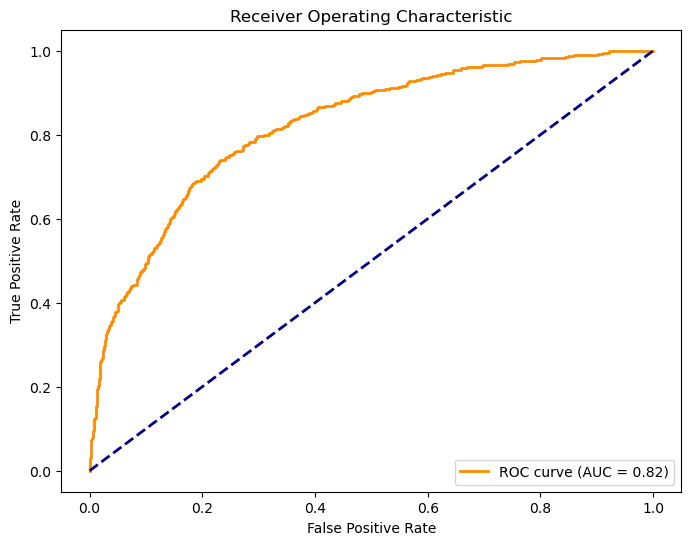

In [17]:
from sklearn.metrics import roc_curve, auc

# Get probabilities for the positive class
y_proba = gbm.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
